In [1]:
import sys
sys.path.insert(0,'/Users/blanca/Documents/TESIS/software/Bbarolo')
from pyBBarolo import version
print (version)

1.3.3dev


In [2]:
from pyBBarolo.bayesian import BayesianBBarolo

In [3]:
from dynesty import plotting as dyplot

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pyBBarolo.BB_interface import libBB

In [5]:

import ctypes, time, copy
from pyBBarolo import Param, Rings, FitMod3D, reshapePointer, vprint, isIterable
import os
import gc

In [6]:
# Set a different temporary directory
#os.environ['TMPDIR'] = os.path.join(os.path.expanduser('~'), 'tmp')

# Create the temporary directory if it doesn't exist
#if not os.path.exists(os.environ['TMPDIR']):
#    os.makedirs(os.environ['TMPDIR'])

In [7]:
def my_norm(model,data):
    nrm = np.nansum(data)/np.nansum(model)
    return nrm*model

def res_Gaussian(data,model,noise,mask,multiplier=1):
    """
    Gaussian residuals with noise
    """

    data *= mask
    model = my_norm(model,data)
    res = np.nansum((data-model)**2)

    return multiplier*res/(noise*noise)

def res_abs(data,model,noise,mask,multiplier=1):
    """
    Use absolute difference
    """
    
    data *= mask
    model = my_norm(model,data)
    res = np.nansum(np.abs(data-model))

    return multiplier*res/noise

In [8]:

class BayesianBBaroloMod(BayesianBBarolo):

    def __init__(self,fitsname,**kwargs):
        """ Initialize the BayesianBBarolo class.
    
        Parameters
        ----------
        fitsname : str
            The name of the fits file with the datacube to fit.
        **kwargs : dict
            Any other parameter to be passed to the BBarolo's library.
        """

        super(BayesianBBaroloMod,self).__init__(fitsname,**kwargs)
        self.noise=None
        self.Npix=None

    
    def _log_likelihood(self,theta):
        """ Likelihood function for the fit """
        
        rings = self._update_rings(self._inri,theta)

        # Calculate likelihood 
        if self.noise is None: self.noise=np.nanstd(self.data[0,:,:])
        if self.Npix is None:  self.Npix=np.prod(self.data.shape)

        if self.useBBres:
            # Calculating residuals through BBarolo directly
            res = libBB.Galfit_calcresiduals(self._galfit,rings._rings)
        else: 
            # Calculating residuals manually            

            # Recompute the density profile along the current rings and update the rings
            if self.useNorm and self.update_prof:
                self._update_profile(rings)

            # Calculate the model and the boundaries
            mod, bhi, blo, galmod = self._calculate_model(rings)
            
            # Calculate the residuals
            mask = self.mask[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            data = self.data[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            res  = self._calculate_residuals(mod,data,mask)

            libBB.Galmod_delete(galmod)
            
        return -res

    #Uncomment
    #Gaussian 
    #def _calculate_residuals(self,model,data,mask=None):
        
        #Option A: Standard absolute residuals: no noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=1, mask=mask, multiplier=1000)

        #Option B Standard absolute residuals: cube noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=self.noise, mask=mask, multiplier=1000)

        #Option C Standard Gaussian residuals: cube noise,
        res=res_Gaussian(model=model, data=data, noise=self.noise, mask=mask, multiplier=1)

        #Option D Gaussian residuals: no noise
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1)

        #Option E Gaussian residuals: no noise, multiplied by 1000
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1000)


        return res

In [9]:
# Name of the FITS file to be fitted
model = "model4_test_container"
fitsname = f"/home/user/THESIS/models/model4/model4.fits"
freepar = ['vrot','vdisp','inc_single','phi_single']
#Uncomment to fit the density
#freepar = ['vrot','vdisp','dens','inc_single','phi_single']
output = "/home/user/THESIS/testing_in_container"

In [10]:

# Creating an object for bayesian barolo
f3d = BayesianBBaroloMod(fitsname)

# Initializing rings. 
f3d.init(radii=np.arange(30,240,60),xpos=25.5,ypos=25.5,vsys=0.0,\
         vrot=100,vdisp=10,vrad=0,z0=30,inc=60,phi=0)

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0,outfolder=f"{output}/{model}",plotmask=True, threads=8)
#To remove the mask
#f3d.set_options(mask="NONE",linear=0,outfolder=f"output/{model}",plotmask=True)

f3d.show_options()

# Default priors are uniform and the default boundaries for the fit are in f3d.bounds.
f3d.bounds['vrot']  = [0,250]
f3d.bounds['vdisp'] = [1,40]
f3d.bounds['inc']   = [20,80]
f3d.bounds['phi']   = [-20,20]
f3d.bounds['z0']    = [0,60]
f3d.bounds['xpos']  = [20,30]
f3d.bounds['ypos']  = [20,30]
f3d.bounds['vsys']  = [-20,20]
f3d.bounds['dens']  = [1,30]


# Keywords to be passed to the sample run
run_kwargs = dict()
# Keywords to be passed to the 
sample_kwargs = dict()

# Running the fit with dynesty.
f3d.compute(threads=8,useBBres=False,method='dynesty',dynamic=True,
            freepar=freepar,run_kwargs=run_kwargs,sample_kwargs=sample_kwargs)


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 

##### Input parameters for BBarolo #####
FITSFILE           /home/user/THESIS/models/model4/model4.fits 
THREADS            8 
OUTFOLDER          /home/user/THESIS/testing_in_container/model4_test_container 
TWOSTAGE           False 
MASK               SEARCH 
LINEAR             0 
PLOTMASK           True 



AttributeError: 'BayesianBBaroloMod' object has no attribute 'bounds'

In [ ]:
print (f3d.params,f3d._log_likelihood(f3d.params))

# Writing best model and plots (experimental, to be checked)
f3d.write_bestmodel()

# Print some statistics of the sample
f3d.print_stats()


[124.68548392 126.05334684 125.34234529 126.14073673  20.29921244
  20.64661319  20.92481573  20.56775371  49.80239664   0.3857403 ] -79787.78352518036

Writing the best model to output directory ... Done!

Best-fit parameters:
       vrot1 =    124.369    -84.341    +84.807
       vrot2 =    126.658    -86.798    +84.315
       vrot3 =    125.367    -86.214    +84.362
       vrot4 =    125.767    -85.885    +85.224
      vdisp1 =     20.391    -13.171    +13.581
      vdisp2 =     20.662    -13.483    +13.032
      vdisp3 =     20.894    -13.736    +12.972
      vdisp4 =     20.485    -13.376    +13.540
         inc =     49.873    -20.127    +20.452
         phi =      0.366    -13.894    +13.505

Maximum logl: -16.83626972419622 at:
       vrot1 =     88.374 
       vrot2 =    160.305 
       vrot3 =     35.441 
       vrot4 =    203.470 
      vdisp1 =     12.740 
      vdisp2 =     39.030 
      vdisp3 =     35.185 
      vdisp4 =     22.424 
         inc =     59.137 
         ph

(         niter: 11732
          ncall: array([1, 1, 1, ..., 1, 1, 1])
            eff: 28.431562621170997
        samples: array([[ 25.52647506,  53.85668778,  33.04321232, ...,   1.68435355,
          76.24892584,  12.19250865],
        [ 64.84690813,  88.72023187,  70.61416295, ...,   6.43864167,
          22.12815384,   5.51353246],
        [ 34.39281384,  36.14494283,  33.72378292, ...,   5.72601245,
          76.30765227,  -7.45075627],
        ...,
        [161.44105879, 145.56683223, 160.06295777, ...,   5.63748941,
          60.52594103,  19.03359231],
        [156.34208328, 121.99366589, 170.36606721, ...,   2.9588347 ,
          77.31575799,  16.42298208],
        [158.36068467, 129.28472771, 126.12543373, ...,  37.95039995,
          75.53890787,  18.2968371 ]])
     samples_id: array([   2,   32,   80, ...,  409,  463, 4235])
  samples_batch: array([0, 0, 0, ..., 0, 0, 8])
     samples_it: array([   0,    0,    0, ..., 1494, 2084, 7078])
      samples_u: array([[0.1021059 

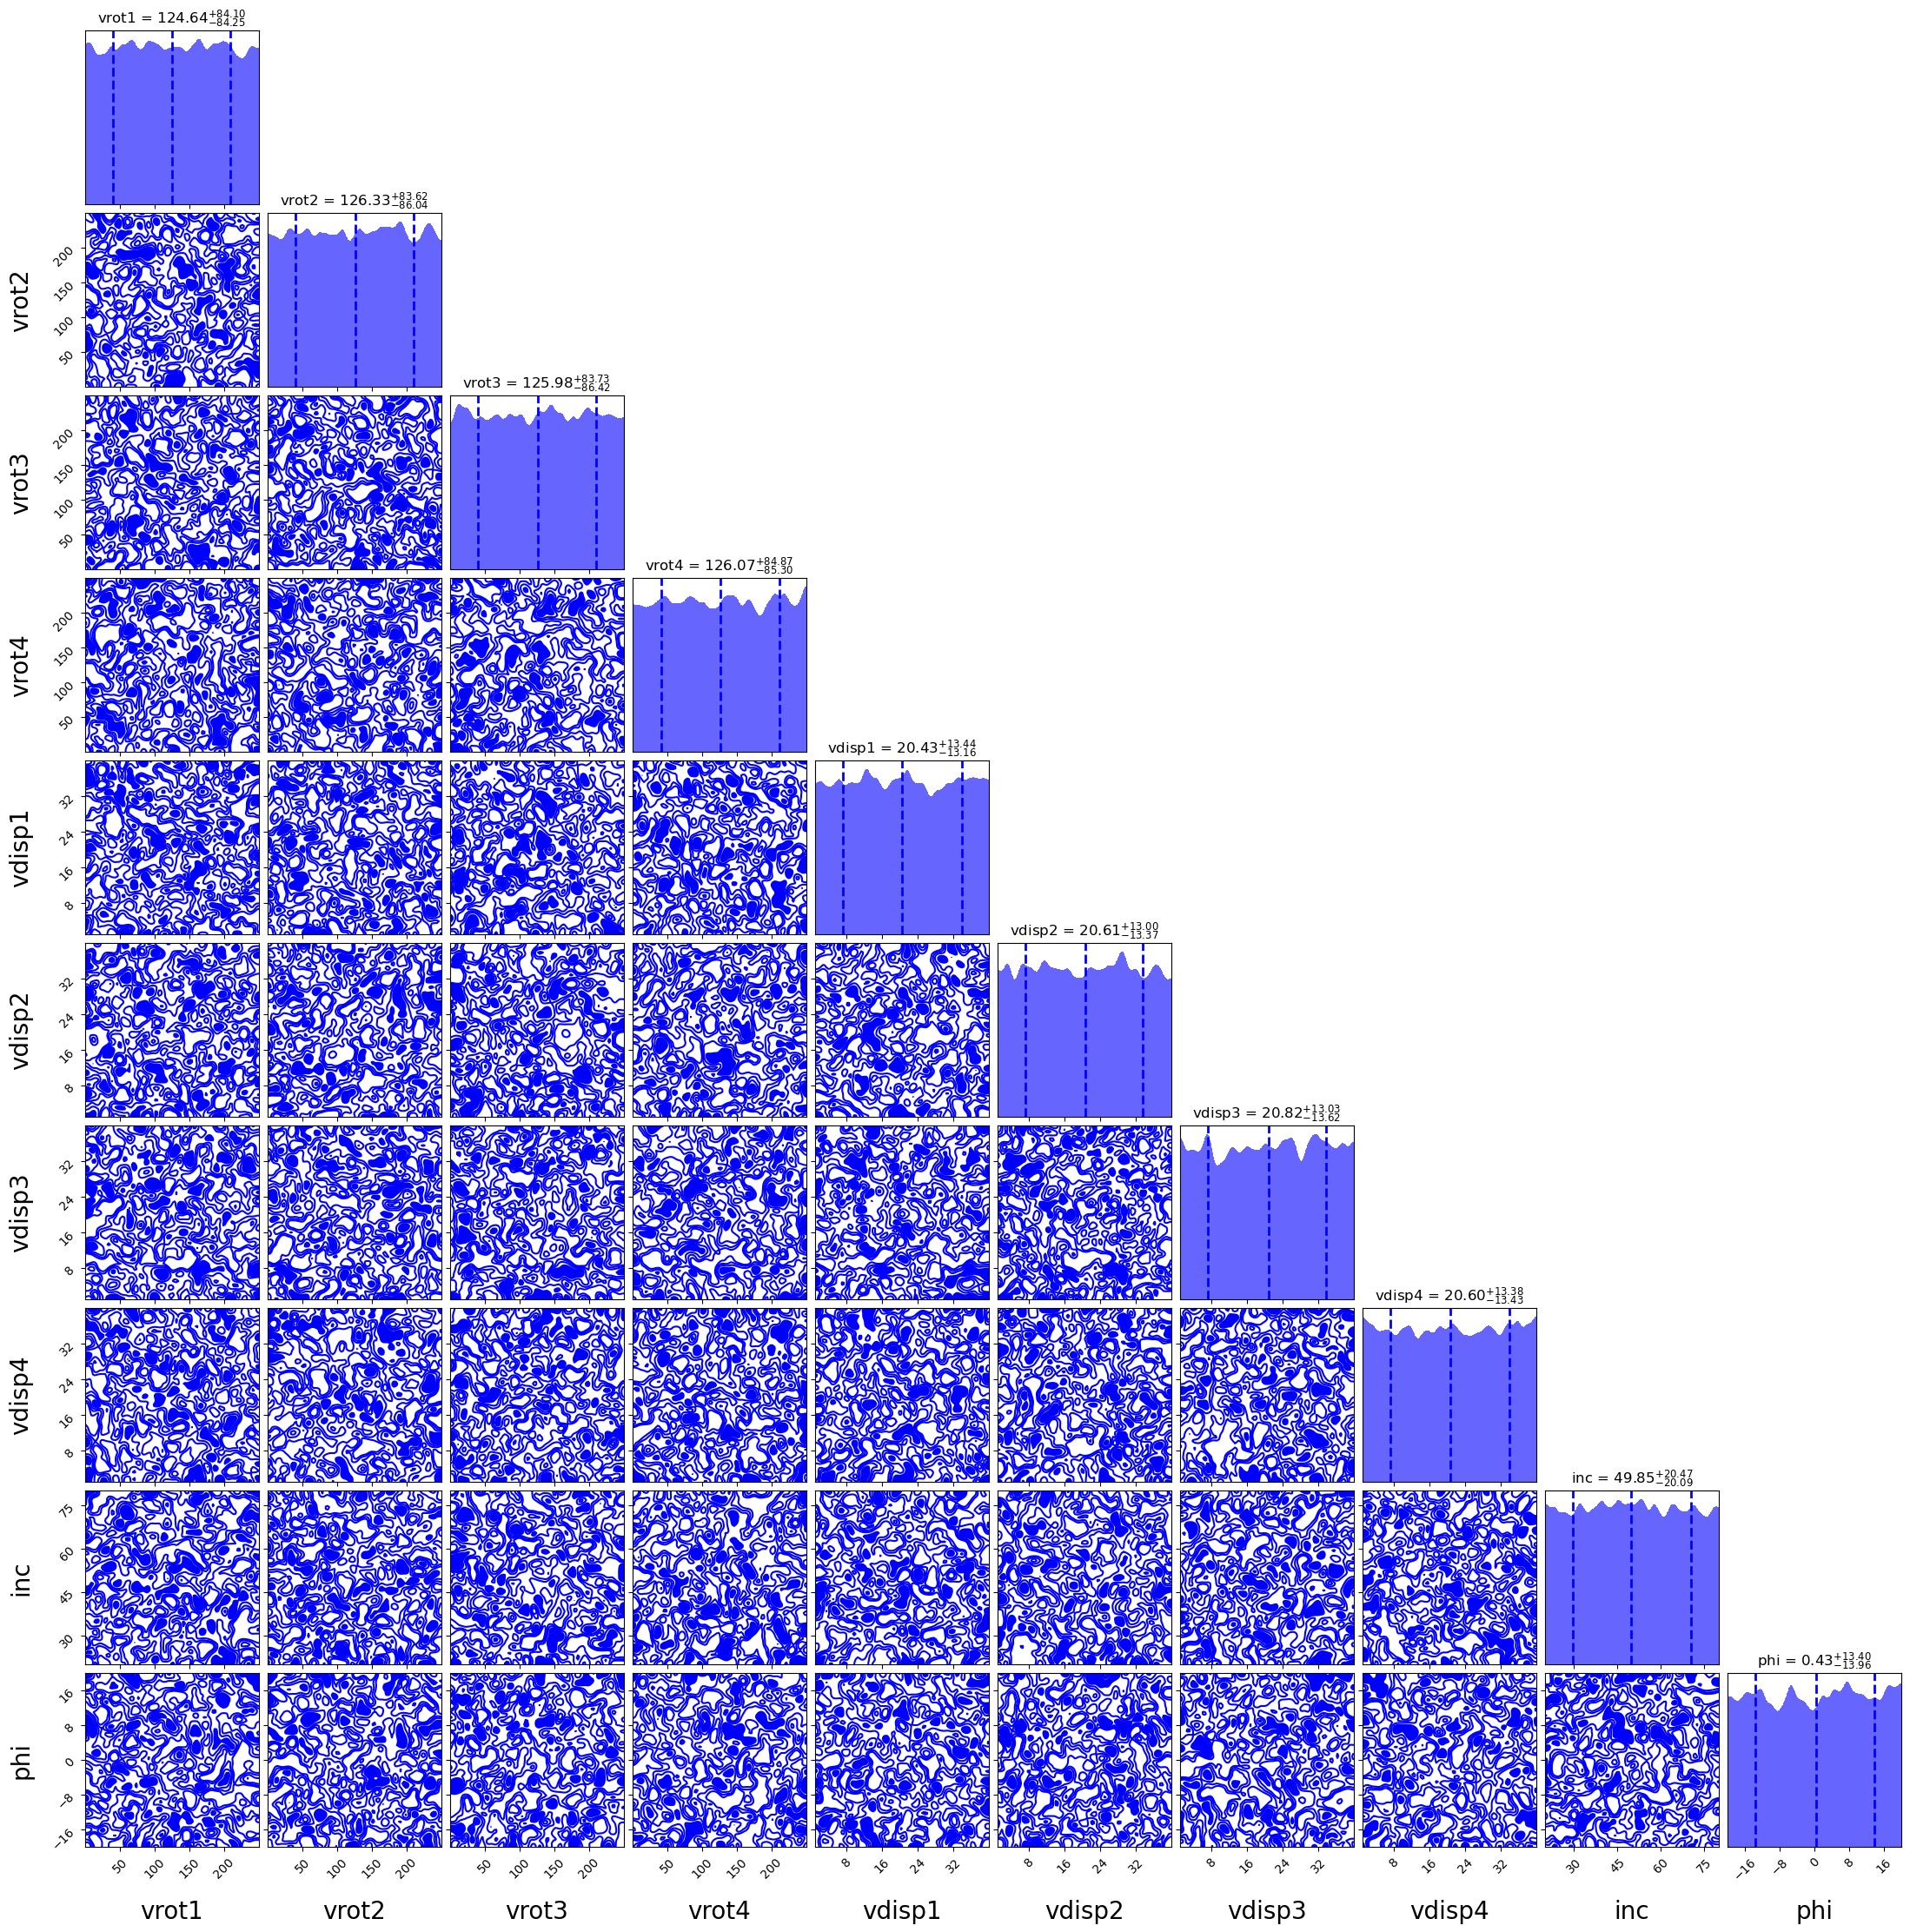

In [ ]:
# Plot the 2-D marginalized posteriors.
quantiles = [0.16,0.50,0.84]
cfig, caxes = dyplot.cornerplot(f3d.results,show_titles=True,title_quantiles=quantiles,
                                quantiles=quantiles, color='blue',max_n_ticks=5, \
                                labels=f3d.freepar_names, label_kwargs=dict(fontsize=20))
cfig.savefig(f'{output}/{model}/{model}_corner.pdf',bbox_inches='tight')

# Saving samples
np.save("dynesty_samples.npy", f3d.results.samples)

In [ ]:
del f3d
gc.collect()

9954